In [3]:
import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

test_percent = .1
num_timesteps = 60

Define Model Function


In [ ]:
def transformer_model(input_shape, num_heads, ff_dim, num_blocks, dropout_rate):
    inputs = keras.Input(shape=input_shape)

    x = inputs
    for _ in range(num_blocks):
        # Multi-head self-attention
        x1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=input_shape[1], dropout=dropout_rate
        )(x, x)
        x1 = layers.Dropout(dropout_rate)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x + x1)

        # Feed-forward neural network
        x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x1)
        x2 = layers.Dropout(dropout_rate)(x2)
        x2 = layers.Conv1D(filters=input_shape[1], kernel_size=1)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x1 + x2)

        x = x2

    # Global average pooling and dense layers
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [2]:
def make2D(arr):
    return np.reshape(arr,(arr.shape[0],1))
def fillNan(time_series_array):
    # Forward fill NaN values
    forward_filled = np.where(np.isnan(time_series_array), np.roll(time_series_array, 1), time_series_array)

    # Backward fill NaN values
    backward_filled = np.where(np.isnan(forward_filled), np.roll(forward_filled, -1), forward_filled)

    # Calculate the average of the preceding and succeeding non-NaN values
    filled_values = (forward_filled + backward_filled) / 2

    # Update NaN values with the calculated average
    time_series_array[np.isnan(time_series_array)] = filled_values[np.isnan(time_series_array)]
    return time_series_array

Import and Split Data

In [4]:
# data = pd.read_csv("NVidia_stock_history.csv")
# data
# split_idx = int(len(data) * (1-test_percent))
# train_df= data.iloc[:split_idx]
# test_df = data.iloc[split_idx:]

train_df = pd.read_csv("Google_Stock_Price_Train.csv")
test_df = pd.read_csv("Google_Stock_Price_Test.csv")

training_set = fillNan(make2D(train_df.loc[:,'Open'].values))
test_set = fillNan(make2D(test_df.loc[:,'Open'].values))

NameError: name 'fillNan' is not defined

Create scaler

In [4]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaler = StandardScaler()
scaled_training_set = scaler.fit_transform(np.log(training_set))
scaled_test_set = scaler.fit_transform(np.log(np.concatenate((training_set[-num_timesteps:,:],test_set))))
scaled_test_set.shape


(80, 1)

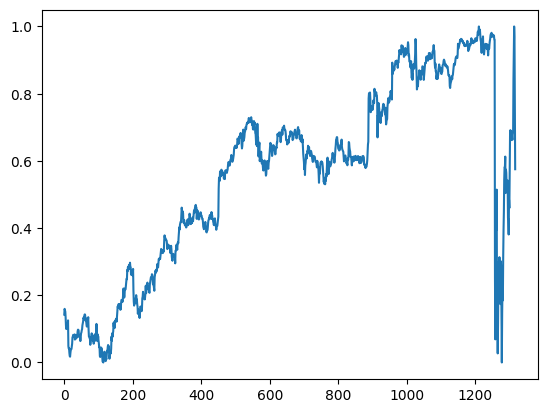

In [5]:
plt.plot(np.concatenate((scaled_training_set , scaled_test_set[-num_timesteps:,:])))

Scale and split training set

In [6]:
# Create X_train and y_train
X_train = []
y_train = []

for i in range(len(scaled_training_set) - num_timesteps):
    X_train.append(scaled_training_set[i:i+num_timesteps])
    y_train.append(scaled_training_set[i+num_timesteps])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape X_train to match the input shape expected by the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))



Make the model and Train

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])  # Shape of input data
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed-forward network inside transformer
num_blocks = 4  # Number of transformer blocks
dropout_rate = 0.2

# Create the transformer model
model = transformer_model(input_shape, num_heads, ff_dim, num_blocks, dropout_rate)

# Compile the model
model.compile(optimizer="adam", loss="mse")

model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)



In [7]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

regressor = Sequential()
regressor.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam',loss='mean_squared_error')
regressor.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
38/38 [==============================] - 3s 34ms/step - loss: 0.0543
Epoch 2/100
38/38 [==============================] - 1s 34ms/step - loss: 0.0072
Epoch 3/100
38/38 [==============================] - 1s 36ms/step - loss: 0.0061
Epoch 4/100
38/38 [==============================] - 1s 37ms/step - loss: 0.0060
Epoch 5/100
38/38 [==============================] - 1s 37ms/step - loss: 0.0061
Epoch 6/100
38/38 [==============================] - 1s 38ms/step - loss: 0.0064
Epoch 7/100
38/38 [==============================] - 1s 38ms/step - loss: 0.0052
Epoch 8/100
38/38 [==============================] - 1s 37ms/step - loss: 0.0052
Epoch 9/100
38/38 [==============================] - 1s 37ms/step - loss: 0.0045
Epoch 10/100
38/38 [==============================] - 1s 37ms/step - loss: 0.0052
Epoch 11/100
38/38 [==============================] - 1s 37ms/step - loss: 0.0045
Epoch 12/100
38/38 [==============================] - 1s 38ms/step - loss: 0.0041
Epoch 13/100
38/38 [=====

Scale test Data

In [8]:
X_test = []

for i in range(num_timesteps,len(scaled_test_set)):
    X_test.append(scaled_test_set[i-num_timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test

array([[[0.38299617],
        [0.39017571],
        [0.36894586],
        ...,
        [0.54148116],
        [0.42998778],
        [0.42370838]],

       [[0.39017571],
        [0.36894586],
        [0.46595045],
        ...,
        [0.42998778],
        [0.42370838],
        [0.38092821]],

       [[0.36894586],
        [0.46595045],
        [0.43464019],
        ...,
        [0.42370838],
        [0.38092821],
        [0.48425113]],

       ...,

       [[0.56036573],
        [0.42522452],
        [0.37428554],
        ...,
        [0.84158672],
        [0.91671941],
        [1.        ]],

       [[0.42522452],
        [0.37428554],
        [0.2541503 ],
        ...,
        [0.91671941],
        [1.        ],
        [0.96857358]],

       [[0.37428554],
        [0.2541503 ],
        [0.06883056],
        ...,
        [1.        ],
        [0.96857358],
        [0.76245284]]])

Predict fucture prices

In [10]:
# predicted_stock_price = model.predict(X_train)
# print(X_test)
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
actual_stock_price = test_set
predicted_stock_price = np.exp(predicted_stock_price)


1/1 [==============================] - 1s 556ms/step


Plot differences

array([[789.2781 ],
       [786.7118 ],
       [784.7141 ],
       [784.0371 ],
       [785.59357],
       [790.3221 ],
       [797.0879 ],
       [802.77966],
       [805.7603 ],
       [806.26685],
       [805.3765 ],
       [804.06537],
       [802.9979 ],
       [802.7414 ],
       [803.36365],
       [806.4556 ],
       [812.5831 ],
       [820.77106],
       [827.311  ],
       [827.15594]], dtype=float32)

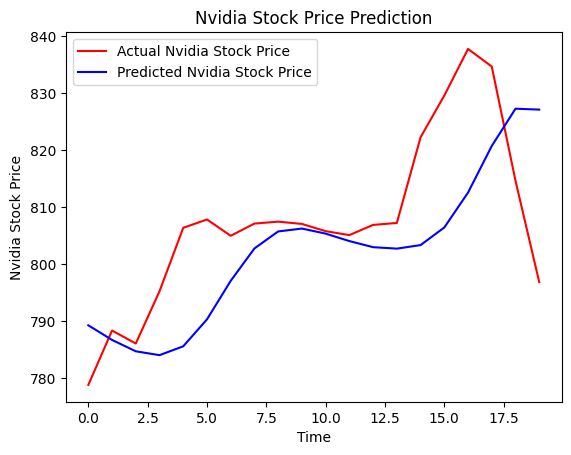

In [12]:
plt.plot(actual_stock_price,color = 'red',label='Actual Nvidia Stock Price')
plt.plot(predicted_stock_price,color = 'blue',label='Predicted Nvidia Stock Price')
plt.title('Nvidia Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nvidia Stock Price')
plt.legend()
predicted_stock_price


Error

RMSE = 13.975909676333652
MAE  = 10.598847167968751


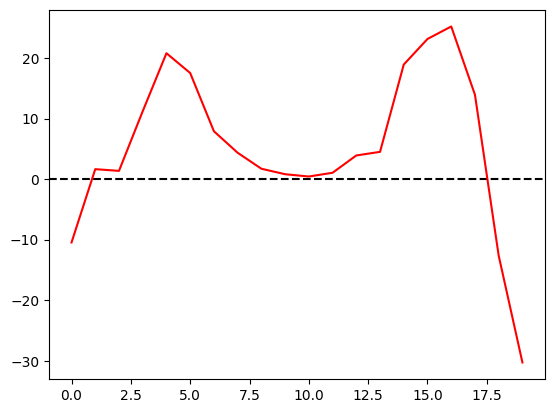

In [13]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

diff = actual_stock_price-predicted_stock_price

plt.axhline(y=0,color='black',linestyle='--')
plt.plot(diff,color = 'red')

mse = mean_squared_error(actual_stock_price, predicted_stock_price)
mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
print(f"RMSE = {math.sqrt(mse)}")
print(f'MAE  = {mae}')